# Sentiment Analysis of Financial News

The data source is available at [Kaggle](https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news?resource=download). 

**Context**: This dataset (FinancialPhraseBank) contains the sentiments for financial news headlines from the perspective of a retail investor.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

import nltk
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import GloVe

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

C:\Users\oluse\anaconda3\envs\udacitydlnndg\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\oluse\anaconda3\envs\udacitydlnndg\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [2]:
os.getcwd()

'D:\\Data\\PyCharmProjects\\MAS-sentiment-analysis\\sent_analysis'

In [3]:
data = pd.read_csv("D:\Data\PyCharmProjects\MAS-sentiment-analysis\data/financial_news.csv", names=['sentiment', 'news'])
data.sample(10)

,sentiment,news
2354,neutral,`` Fixed Mobile Convergence solutions represen...
1732,positive,The developers of that project predict that on...
4365,neutral,Why put up costly cell phone towers in thinly ...
3275,neutral,The lay-offs will start gradually and will las...
3447,neutral,Vaisala 's Present Weather Detector measures v...
365,positive,Ruukki 's order book at the end of 2010 was 30...
4033,negative,Operating loss of the Pulp & Paper Machinery u...
661,positive,The loss for the third quarter of 2007 was EUR...
3884,neutral,The Oulu plant employs approximately 120 people .
3430,neutral,TN means that the handset supports TeliaSonera...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   news       4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


Our dataframe consists of 4,846 rows with just two columns i.e sentiment and news.

## Data Analysis

In [5]:
value_counts = data['sentiment'].value_counts(normalize=True) * 100  # Get percentages
count_with_percentages = data['sentiment'].value_counts().to_frame('counts')  # Get counts
count_with_percentages['percentage'] = round(value_counts, 2)  # Add percentages to the DataFrame

print(count_with_percentages)

           counts  percentage
sentiment                    
neutral      2879       59.41
positive     1363       28.13
negative      604       12.46


In [6]:
def pie_plot():
    # Calculate counts and percentages
    value_counts = data['sentiment'].value_counts()
    percentages = value_counts / value_counts.sum() * 100
    
    # Create labels with both values and percentages
    labels = [f'{label}: {count}' for label, count in zip(value_counts.index, value_counts)]
    
    # Define the explode parameter to separate the "negative" slice
    explode = [0.05 if label == 'negative' else 0 for label in value_counts.index]
    
    # Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(value_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors, explode=explode)
    plt.title('Sentiment Distribution on Financial Dataset')
    plt.show()

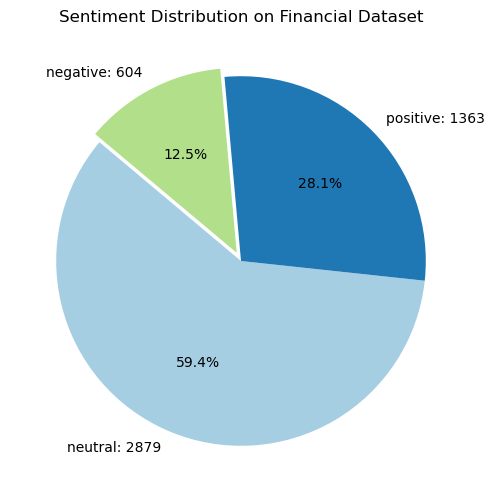

In [7]:
pie_plot()

## Data Preprocessing

In [8]:
# Encode the sentiment labels to integers
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['sentiment'])

With the encoder, we have 
- negative = 0, 
- neutral = 1, 
- positive = 2.

In [9]:
data.sample(50)

,sentiment,news,sentiment_encoded
305,positive,This new representation extends Comptel 's glo...,2
3361,neutral,The share subscription period for stock option...,1
1763,positive,The concept enables a commercially affordable ...,2
3640,neutral,"In the Czech Republic , the profiling unit at ...",1
2513,neutral,mr Bakman sees also expansion options on the T...,1
560,positive,Basware Corporation stock exchange release Aug...,2
125,positive,Sanoma Magazines ' net sales are estimated to ...,2
869,neutral,"Nokia will provide Indosat turnkey services , ...",1
2302,positive,"Tectia Corporation HEL : TEC1V , a provider of...",2
1239,neutral,HELSINKI ( AFX ) - Outokumpu said it has agree...,1


In [10]:
# Split the data into features (X) and target (y)
X = data['news'].values
y = data['sentiment_encoded'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Use GloVe for the vocabulary
glove = GloVe(name='6B', dim=100)  # 100-dimensional GloVe vectors

# Check if '<unk>' is in the GloVe vocabulary, if not, add it
if '<unk>' not in glove.stoi:
    unk_idx = len(glove.stoi)
    glove.stoi['<unk>'] = unk_idx
    # Add a random vector for '<unk>', or use zeros
    glove.vectors = torch.cat([glove.vectors, torch.zeros(1, glove.dim)], dim=0)
else:
    unk_idx = glove.stoi['<unk>']

In [30]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.vocab = vocab
        self.max_len = max_len
        self.unk_idx = self.vocab.stoi.get('<unk>', len(self.vocab.stoi))
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize and map to vocabulary indices
        tokenized = [self.vocab.stoi.get(token, self.unk_idx) for token in text.split()]
        return torch.tensor(tokenized, dtype=torch.long), label


In [22]:
# class SentimentDataset(Dataset):
#     def __init__(self, texts, labels, vocab, max_len):
#         self.texts = texts
#         self.labels = torch.tensor(labels, dtype=torch.long)
#         self.vocab = vocab
#         self.max_len = max_len
#     
#     def __len__(self):
#         return len(self.texts)
#     
#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         label = self.labels[idx]
#         
#         # Tokenize and map to vocabulary indices
#         tokenized = [self.vocab.stoi[token] for token in text.split()]
#         return torch.tensor(tokenized, dtype=torch.long), label

# class SentimentDataset(Dataset):
#     def __init__(self, texts, labels, vocab, max_len):
#         self.texts = texts
#         self.labels = torch.tensor(labels, dtype=torch.long)
#         self.vocab = vocab
#         self.max_len = max_len
#     
#     def __len__(self):
#         return len(self.texts)
#     
#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         label = self.labels[idx]
#         
#         # Tokenize and map to vocabulary indices
#         tokenized = [self.vocab.stoi.get(token, self.vocab.stoi['<unk>']) for token in text.split()]
#         return torch.tensor(tokenized, dtype=torch.long), label


In [32]:
# Use GloVe for the vocabulary
# glove = GloVe(name='6B', dim=100)  # 100-dimensional GloVe vectors

# Define max length for padding
max_len = 100

# Create datasets
train_dataset = SentimentDataset(X_train, y_train, glove, max_len)
test_dataset = SentimentDataset(X_test, y_test, glove, max_len)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: pad_sequence([item[0] for item in x], batch_first=True, padding_value=0))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: pad_sequence([item[0] for item in x], batch_first=True, padding_value=0))

In [33]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Take the last hidden state
        out = self.fc(lstm_out)
        return out

In [34]:
vocab_size = len(glove.stoi)
embedding_dim = 100
hidden_dim = 128
output_dim = 3  # Three sentiment classes

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)

# Initialize the embeddings with GloVe vectors
model.embedding.weight.data.copy_(glove.vectors)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [35]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for batch in train_loader:
        texts, labels = batch
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

ValueError: too many values to unpack (expected 2)

In [36]:
model.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for batch in test_loader:
        texts, labels = batch
        predictions = model(texts)
        test_loss += criterion(predictions, labels).item()
        _, predicted = torch.max(predictions, 1)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
accuracy = correct / len(test_dataset)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

ValueError: too many values to unpack (expected 2)